# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели, введение в конкурсную задачу


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 апреля 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 апреля, -4 балла после 06:00 24 апреля, -6 баллов после 06:00 1 мая

Имеется ввиду именно сдача данного ДЗ, а не конечного результата по конкурсу (см ниже).<br\>
Жесткий дедлайн по конкурсной задаче - 14 мая 23:59 GMT.

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [274]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize as nlz
from numpy import apply_along_axis as apl
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [275]:
USER_NAME = u"Пучкин".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L1 регуляризацией с помощью метода  Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Считать градиент по мини батчам
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

## Имплементация (6 баллов)

In [411]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, max_iter=10):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.max_iter = max_iter
        
    def sigmoid(self, z):
        return 1/(1+np.exp((-1)*z))

    def grad(self, x, beta, y):
        res = self.C * np.sign(beta)
        for i in xrange(len(res)):
            res[i] += y * x[i] * (self.sigmoid(x.dot(beta) * y)-1)
        return res
    
    def grad_vec(self, x, beta, y):
        res = self.C * np.sign(beta)
        for i in xrange(len(res)):
            res[i] += np.sum([y[j]*x[j][i]*(self.sigmoid(y[j]*(x[j].dot(beta)))-1) for j in xrange(len(y))])
        return res
    
    def error(self, x, beta, y):
        return (-1) * np.sum(np.array([np.log(self.sigmoid(y[j] * x[j].dot(beta))) for j in xrange(len(y))])) + \
                             self.C * np.sum(np.abs(beta))
    
    
    def fit(self, X, y):
        '''
        Обучение модели
        '''
        prec_tmp = 0
        y_tmp = np.zeros(X.shape[0], dtype='int')
        y_proba_tmp = np.zeros(X.shape[0], dtype='float')
        L_tmp = np.zeros(self.max_epoch, dtype='float')
        x_norm = np.hstack((np.ones(X.shape[0], dtype='int').reshape(X.shape[0], 1), X))
        for o in xrange(self.max_iter):
            self.beta = np.random.random(x_norm.shape[1])-0.5
            self.new_beta = np.random.random(x_norm.shape[1])-0.5
            self.L = np.zeros(self.max_epoch, dtype='float')
            y1 = y.copy()
            y1[y==0] = -1
            for n_epoch in xrange(self.max_epoch):
                for i in np.random.choice(X.shape[0], X.shape[0], replace=False):
                    self.beta = self.new_beta.copy()
                    self.new_beta = self.new_beta - self.alpha / float(n_epoch+1) * self.grad(x_norm[i], self.beta, y1[i])
                self.L[n_epoch] = self.error(x_norm, self.new_beta, y)
            self.y_hat_proba = np.array([self.sigmoid(i.dot(self.new_beta)) for i in x_norm])
            self.y_hat = np.zeros(x_norm.shape[0], dtype='int')
            self.y_hat[(x_norm.dot(self.new_beta)) > 0] = 1
            self.prec = np.sum(self.y_hat==y)/float(len(y))            
            if self.prec > prec_tmp:
                L_tmp = self.L
                prec_tmp = self.prec
                y_tmp = self.y_hat
                y_proba_tmp = self.y_hat_proba
        
        self.y_hat = y_tmp
        self.y_proba_tmp = y_proba_tmp
        self.prec = prec_tmp
        self.L = L_tmp
        return self
    
    def fit_mistakes(self, X, y):
        '''
        Обучение модели (с выводом ошибки для отладки, метод используется для отладки)
        '''
        x_norm = np.hstack((np.ones(X.shape[0], dtype='int').reshape(X.shape[0], 1), X))
        self.beta = np.random.random(x_norm.shape[1])-0.5
        self.new_beta = np.random.random(x_norm.shape[1])-0.5
        self.L = np.zeros(self.max_epoch, dtype='float')
        y1 = y.copy()
        y1[y==0] = -1
        for n_epoch in xrange(self.max_epoch):
            for i in np.random.choice(X.shape[0], X.shape[0], replace=False):
                self.beta = self.new_beta.copy()
                self.new_beta = self.new_beta - self.alpha / float(n_epoch+1) * self.grad(x_norm[i], self.beta, y1[i])
            # self.beta = self.new_beta.copy()
            # self.new_beta = self.new_beta - self.alpha / float(n_epoch+1) * self.grad_vec(x_norm, self.beta, y1)
            self.y_hat_proba = np.array([self.sigmoid(i.dot(self.new_beta)) for i in x_norm])
            self.y_hat = np.zeros(x_norm.shape[0], dtype='int')
            self.L[n_epoch] = self.error(x_norm, self.new_beta, y)
            self.y_hat[self.y_hat_proba > 0.5] = 1
            self.prec = np.sum(self.y_hat==y)/float(len(y))            
            print self.prec
                    
        return self
                
    def predict(self):
        '''
        Возвращение классов
        '''
        return self.y_hat
    
    def predict_proba(self):
        '''
        Возвращение вероятности каждого из классов
        '''
        return y_hat_proba
    
    def vec(self):
        return self.new_beta
    
    def precision(self):
        return self.prec

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

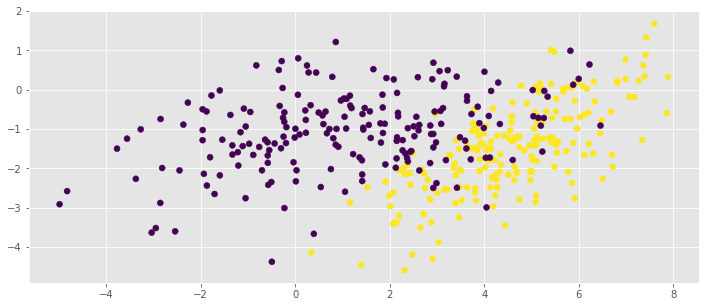

In [418]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

In [427]:
model = MySGDClassifier(C=0.001, alpha=0.05, max_epoch=200, max_iter=20)
model.fit(X, y)

MySGDClassifier(C=0.001, alpha=0.05, max_epoch=200, max_iter=20)

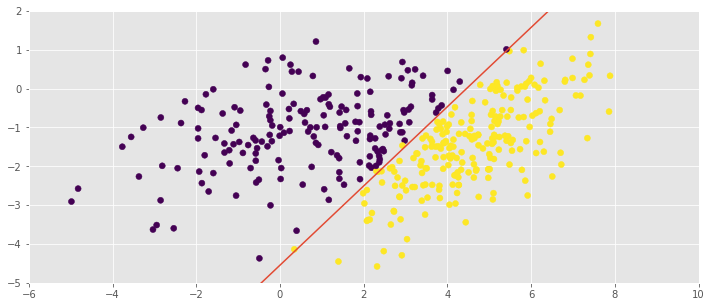

In [428]:
plt.scatter(X[:,0], X[:,1], c=model.predict())

x1 = np.linspace(-6, 8, 2)
y1 = model.vec()[1] * x1 + model.vec()[0]

plt.ylim(ymin=-5, ymax=2)
plt.xlim(xmin=-6, xmax=10)

plt.plot(x1, y1)

In [429]:
model.prec

0.89500000000000002

## Анализ сходимости (2 балл)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

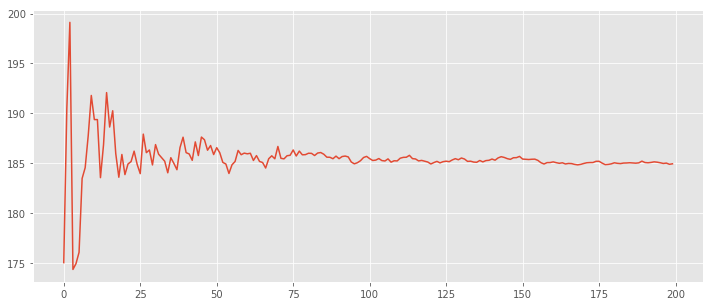

In [430]:
plt.plot(model.L)

# Введение в конкурсную задачу

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

### Правила
* Объединяться в команды по правилам конкурса можно, но по правилам нашего курса - нельзя)
* Вы можете использовать любой алгоритм, даже неизученный в нашем курсе (если на защите сможете объяснить как он работает)
* Имейте ввиду, что вы должны отправить результаты строго до 14 мая 23:59 GMT на сайт соревнования (раздел submission). Без результата в leaderboard оценка выставлена не будет.

## Данные

Для того, чтобы получить данные необходимо зарегистрироваться на сайте соревнования. 

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


Данные поставляются в двух форматах:
* В формате json содержится полная информация по текущему состоянию раунда
* В табличном формате упрощенная аггрерированная информация по текущему состоянию раунда

В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если данные не будут помещаться вам с оперативную память, рекомендуется совершить предобработку в python, а  моделирование выполнять с помощью [vowpal wabbit](https://github.com/JohnLangford/vowpal_wabbit).

In [ ]:
# Загрузка данных целиком
df_list = []
for chunk in range(1,5):
    filepath = './trainingData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))

df_data = pd.concat(df_list)

# Загрузка одной части данных
# filepath = './trainingData_tabular_chunk1.csv'
# df_data = pd.read_csv(filepath, sep=',')

In [ ]:
df_data.shape

In [ ]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [ ]:
df_data.head().T

In [ ]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощьб one-hot кодирования, добавьте к датасету и удалите прежние столбцы

In [ ]:
## Youd Code Here

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Обучите модуль из первой части этого ДЗ на данных

In [ ]:
## Youd Code Here

## Применение модели (3 балла)
#### Задание
* Загрузите тестовые данные
* Выполните те же операции с датасетом, что и с обучающей выборкой
* Примените модель и загрузите решение на страницу конкурса
* Напечатайте ваш ник и оценку качества, полученную после загрузки

Судя по описанию, submission file должен состоять из одного столбца с числами, соответствующим вероятностям победы игрока.

In [ ]:
## Youd Code Here